In [1]:
using GoldGates
using MSSim: Optimizers as Opts, SegSeq as SS, SymLinear as SL, Sequence as Seq, Utils as U
using BenchmarkTools
using NLopt
using Statistics
using PyPlot
using JSON
using Dates

include("../src/utils.jl")
ENV["MPLBACKEND"] = "module://matplotlib_inline.backend_inline"

"module://matplotlib_inline.backend_inline"

In [2]:
sysparams = open("../system_params/072125_goldparams_13ions.json") do io
    read(io, GoldGates.SystemParams; format=:json)
end;

In [3]:
# Constants across notebook
const nions = 13

const objfunc = Opts.autodiff(_objfunc);
const modes = Seq.Modes()
const nions = 13
const ion1 = 5
const ion2 = 9
for i in 1:nions
    push!(modes, 2π * sysparams.modes.radial1[i], sysparams.participation_factors[i][ion1] * sysparams.participation_factors[i][ion2] * sysparams.lamb_dicke_parameters[i]^2)
end

In [4]:
const nseg = 25
buf_opt = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_allδ), Val(SS.mask_allδ));

amp_funcs = amp_base_funcs(nseg);
const nlmodel = Seq.Objective(SL.pmask_full,
    ((:dis2, 0), (:disδ2, 0), (:area, 0),
        (:areaδ, 0), (:τ, 0)),
    objfunc, modes, buf_opt,
    freq=Seq.FreqSpec(false, sym=true),    # turn off frequency modulation
    amp=Seq.AmpSpec(cb=amp_funcs, sym=true));

In [5]:
# Set bounds for optimizer
pitime_to_Ω(time) = π / (2 * time)
# this isn't a direct limit on rabi frequency though, just amplitude of each base function
Ωmax = pitime_to_Ω(10)
τmin = 3
τmax = 12
ωmin = 2π * (sysparams.modes.radial1[1])
ωmax = 2π * (sysparams.modes.radial1[2])

const nargs = Seq.nparams(nlmodel)
const tracker = Opts.NLVarTracker(nargs)
for Ω in nlmodel.param.Ωs
    # set the rabi frequency bound on all amplitude base function
    Opts.set_bound!(tracker, Ω, 0, Ωmax)
end
println("Ωmax is $Ωmax")

Opts.set_bound!(tracker, nlmodel.param.τ, τmin, τmax)
println("Total gate time is between $(τmin * nseg) and $(τmax * nseg) us")

for ω in nlmodel.param.ωs
    Opts.set_bound!(tracker, ω, ωmin, ωmax)
end

opt = NLopt.Opt(:LD_LBFGS, nargs)
NLopt.min_objective!(opt, nlmodel)
NLopt.lower_bounds!(opt, Opts.lower_bounds(tracker))
NLopt.upper_bounds!(opt, Opts.upper_bounds(tracker))
NLopt.maxtime!(opt, 10)

Ωmax is 0.15707963267948966
Total gate time is between 75 and 300 us


In [6]:
best_obj = Inf
best_params = nothing
threshold = -Inf  # not setting a threshold

@time for i in 1:200
    global best_obj, best_params
    initial_params = Opts.init_vars!(tracker)
    obj, params, ret = @time NLopt.optimize(opt, initial_params)
    if getfield(NLopt, ret) < 0
        continue
    end
    if obj < best_obj
        best_obj = obj
        area = nlmodel(Val((:area, 0)), params)
        best_status = (
            obj = obj,
            dis = nlmodel(Val((:dis2, 0)), params),
            disδ = nlmodel(Val((:disδ2, 0)), params),
            area = area,
            areaε = abs(area) - π / 2,
            areaδ = nlmodel(Val((:areaδ, 0)), params),
            total_t = nlmodel(Val((:τ, 0)), params),
            Ωmax = params[nlmodel.param.Ωs[1]],
        )
        println(best_status)
        best_params = params
    end
    if best_obj < threshold
        break
    end
end

  0.003379 seconds (236 allocations: 57.891 KiB)
(obj = 0.16431716345473724, dis = 0.0005574573895594247, disδ = 16.150155305309053, area = 1.5702732017206924, areaε = -0.000523125074204156, areaδ = 9.785037166406008, total_t = 191.21813788265683, Ωmax = 0.001364552777114829)
  0.003298 seconds (203 allocations: 49.750 KiB)
  0.005204 seconds (364 allocations: 90.000 KiB)
  0.000702 seconds (29 allocations: 6.250 KiB)
  0.000668 seconds (25 allocations: 5.250 KiB)
  0.003875 seconds (299 allocations: 73.750 KiB)
  0.006508 seconds (449 allocations: 111.250 KiB)
  0.000674 seconds (23 allocations: 4.750 KiB)
  0.000646 seconds (23 allocations: 4.750 KiB)
  0.000723 seconds (26 allocations: 5.500 KiB)
  0.002468 seconds (164 allocations: 40.000 KiB)
  0.005046 seconds (390 allocations: 96.500 KiB)
(obj = 0.008635105669794368, dis = 1.638488120913195e-5, disδ = 0.8552282136083574, area = 1.5707688362375958, areaε = -2.7490557300779983e-5, areaδ = 9.074990859844716, total_t = 253.698400468

{
    "gradient_area_detuning": 8.78771447071629,
    "gradient_displacement_detuning": 0.023811209488069876,
    "enclosed_area": 1.5707955622574767,
    "total_cumulative_displacement": 0.02381120951338063,
    "carrier_pi_time_required": 3.508292498385709,
    "total_displacement": 1.0927174784213899e-7,
    "total_gate_time": 291.8098525333361
}



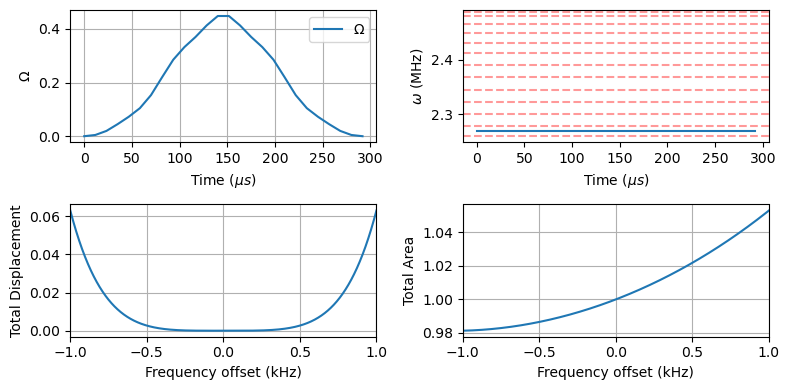

In [7]:
opt_raw_params, metadata = get_metadata_and_plot(nlmodel, best_params;)
println(JSON.json(metadata, 4))

In [9]:
date = Dates.format(Dates.now(), "yyyymmdd")
_ion1 = ion1 - (nions + 1) ÷ 2
_ion2 = ion2 - (nions + 1) ÷ 2
solution_set = GoldGates.GateSolutionSet(params=sysparams,
    XX=Dict("$_ion2,$_ion1" => GoldGates.XXSolution(opt_raw_params, metadata["enclosed_area"], metadata=JSON.json(metadata))))
open("../out/$(date)_am_$(nions)_v3.json", "w") do io
    write(io, solution_set, format=:json)
end

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


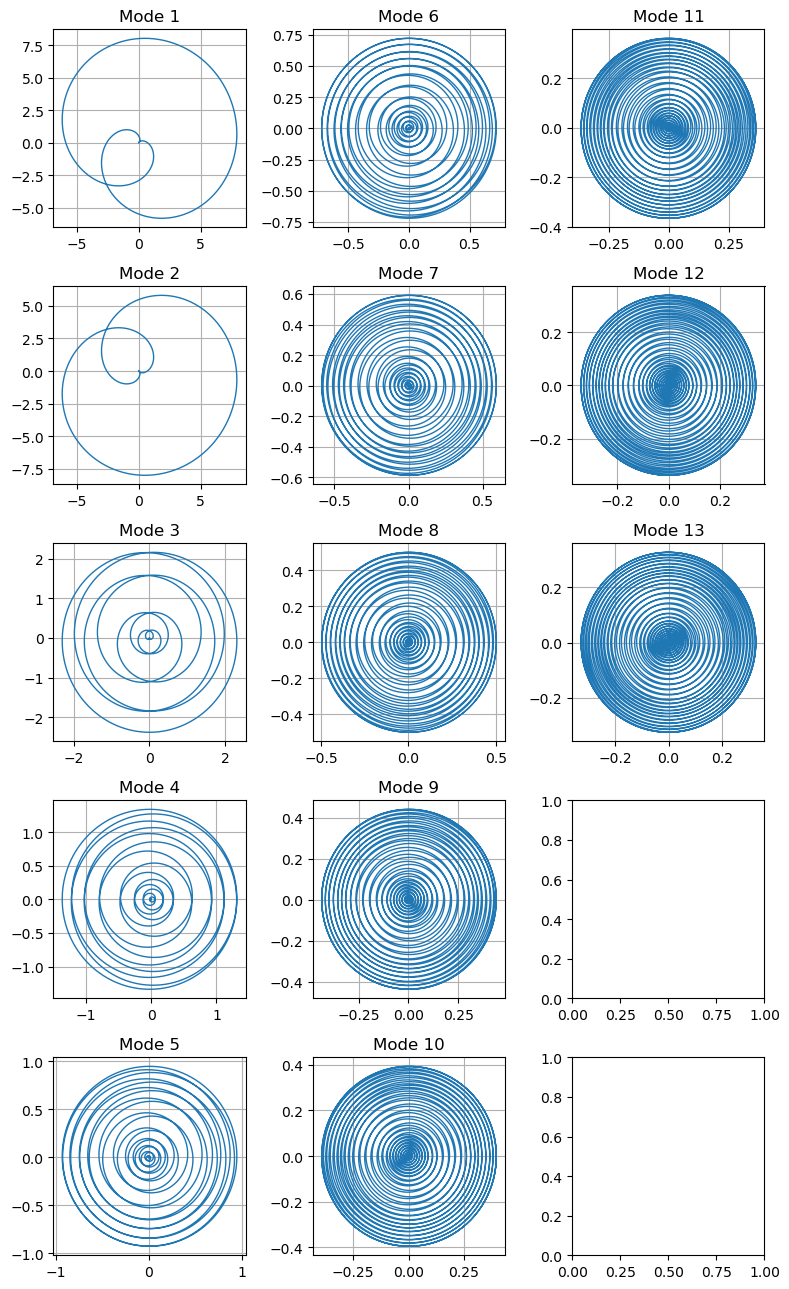

In [ ]:
n = length(modes.modes)  # total number of modes
fig, axes = subplots(cld(n, 3), 3, figsize=(8, n))  # n vertical subplots

for i in 1:n
    _, xs, ys = Seq.get_trajectory(opt_raw_params, 10001; ωm=modes[i][1])
    ax = axes[i]
    ax.plot(xs, ys, lw=1)
    ax.set_title("Mode $i")
    ax.grid(true)
end

tight_layout()
show()